In [1]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
train_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         6480 non-null   float64
 1   date       6480 non-null   object 
 2   city       6480 non-null   object 
 3   lat        6429 non-null   float64
 4   long       6434 non-null   float64
 5   pop        6480 non-null   float64
 6   shop       6480 non-null   object 
 7   brand      6480 non-null   object 
 8   container  6464 non-null   object 
 9   capacity   6465 non-null   object 
 10  price      6480 non-null   float64
 11  quantity   6480 non-null   float64
dtypes: float64(6), object(6)
memory usage: 708.9+ KB


In [4]:
test_df
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1080 non-null   int64  
 1   date       1080 non-null   object 
 2   city       1080 non-null   object 
 3   lat        1072 non-null   float64
 4   long       1067 non-null   float64
 5   pop        1080 non-null   int64  
 6   shop       1080 non-null   object 
 7   brand      1080 non-null   object 
 8   container  1077 non-null   object 
 9   capacity   1076 non-null   object 
 10  price      1080 non-null   float64
 11  quantity   1080 non-null   int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 101.4+ KB


In [5]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

def encode_dates(df, column):
    df = df.copy()
    df[column] = pd.to_datetime(df[column])
    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df = df.drop(column, axis=1)
    return df

In [6]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop id column
    df = df.drop('id', axis=1)
    
    # Remove missing rows
    missing_rows = df.loc[df.isna().all(axis=1), :].index
    df = df.drop(missing_rows, axis=0).reset_index(drop=True)
    
    # Fill numeric missing values with mean
    for column in ['lat', 'long']:
        df[column] = df[column].fillna(df[column].mean())
    
    # Fill ordinal missing values with mode
    df['capacity'] = df['capacity'].fillna(df['capacity'].mode()[0])
    
    # One-hot encode nominal features
    for column in ['city', 'shop', 'brand', 'container']:
        df = onehot_encode(df, column=column)
    
    # Ordinal encode capacity column
    capacity_ordering = ['330ml', '500ml', '1.5lt']
    df['capacity'] = df['capacity'].apply(lambda x: capacity_ordering.index(x))
    
    # Extract date features
    df = encode_dates(df, column='date')
    
    # Split df into X and y
    y = df['quantity']
    X = df.drop('quantity', axis=1)
    
    return X, y

In [7]:
X_train, y_train = preprocess_inputs(train_df)
X_test, y_test = preprocess_inputs(test_df)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [8]:
X_train

,lat,long,pop,capacity,price,city_Athens,city_Irakleion,city_Larisa,city_Patra,city_Thessaloniki,...,brand_gazoza,brand_kinder-cola,brand_lemon-boost,brand_orange-power,container_can,container_glass,container_plastic,date_year,date_month,date_day
0,-0.195837,0.411791,1.361571,-0.003021,-0.281130,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,2.0,-0.5,-0.5,-0.705389,1.417165,-0.706370,-1.46385,-1.593255,0.696733
1,-0.195837,0.411791,1.361571,1.220597,2.051577,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,2.0,-0.5,-0.5,-0.705389,-0.705634,1.415688,-1.46385,-1.593255,0.696733
2,-0.195837,0.411791,1.361571,-1.226639,-0.391627,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,2.0,-0.5,-0.5,1.417658,-0.705634,-0.706370,-1.46385,-1.593255,0.696733
3,-0.195837,0.411791,1.361571,-0.003021,-0.232020,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,-0.5,-0.5,-0.5,-0.705389,1.417165,-0.706370,-1.46385,-1.593255,0.696733
4,-0.195837,0.411791,1.361571,-1.226639,-0.980942,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,-0.5,-0.5,-0.5,1.417658,-0.705634,-0.706370,-1.46385,-1.593255,0.696733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,-0.206183,0.384885,1.334687,1.220597,-0.207465,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,-0.5,-0.5,2.0,-0.705389,-0.705634,1.415688,1.46385,1.593255,0.696733
6476,0.812867,-0.787282,-0.905625,-1.226639,-0.882723,-0.707107,-0.447214,2.236068,-0.447214,-0.447214,...,-0.5,-0.5,-0.5,2.0,1.417658,-0.705634,-0.706370,1.46385,1.593255,0.696733
6477,-0.034567,-1.418088,-0.801683,-0.003021,-0.207465,-0.707107,-0.447214,-0.447214,2.236068,-0.447214,...,-0.5,-0.5,-0.5,-0.5,-0.705389,1.417165,-0.706370,1.46385,1.593255,0.696733
6478,1.425548,-0.313372,-0.009194,1.220597,0.185412,-0.707107,-0.447214,-0.447214,-0.447214,2.236068,...,2.0,-0.5,-0.5,-0.5,-0.705389,-0.705634,1.415688,1.46385,1.593255,0.696733


In [9]:
y_train

0       13280.0
1        6727.0
2        9848.0
3       20050.0
4       25696.0
         ...   
6475    33201.0
6476    46971.0
6477    47708.0
6478    27115.0
6479    30413.0
Name: quantity, Length: 6480, dtype: float64

In [10]:
X_test

,lat,long,pop,capacity,price,city_Athens,city_Irakleion,city_Larisa,city_Patra,city_Thessaloniki,...,brand_gazoza,brand_kinder-cola,brand_lemon-boost,brand_orange-power,container_can,container_glass,container_plastic,date_year,date_month,date_day
0,-0.195837,0.411791,1.326848,1.220597,2.346235,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,2.0,-0.5,-0.5,-0.705389,-0.705634,1.415688,2.04939,-1.593255,0.696733
1,-0.195837,0.411791,1.326848,-1.226639,-0.416181,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,2.0,-0.5,-0.5,1.417658,-0.705634,-0.706370,2.04939,-1.593255,0.696733
2,-0.195837,0.411791,1.326848,-0.003021,-0.440736,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,-0.5,-0.5,-0.5,-0.705389,1.417165,-0.706370,2.04939,-1.593255,0.696733
3,-0.195837,0.411791,1.326848,-0.003021,-0.796781,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,-0.5,-0.5,2.0,-0.705389,1.417165,-0.706370,2.04939,-1.593255,0.696733
4,-0.195837,0.411791,1.326848,1.220597,-0.440736,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,-0.5,-0.5,2.0,-0.705389,-0.705634,1.415688,2.04939,-1.593255,0.696733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,-0.195837,0.411791,1.326848,1.220597,1.634146,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,2.0,-0.5,-0.5,-0.705389,-0.705634,1.415688,2.04939,1.593255,0.696733
1076,-0.195837,0.411791,1.326848,1.220597,1.216714,1.414214,-0.447214,-0.447214,-0.447214,-0.447214,...,-0.5,-0.5,-0.5,2.0,-0.705389,-0.705634,1.415688,2.04939,1.593255,0.696733
1077,-0.034567,-1.418088,-0.803689,-1.226639,-0.416181,-0.707107,-0.447214,-0.447214,2.236068,-0.447214,...,-0.5,2.0,-0.5,-0.5,1.417658,-0.705634,-0.706370,2.04939,1.593255,0.696733
1078,1.425548,-0.313372,-0.003657,1.220597,1.204436,-0.707107,-0.447214,-0.447214,-0.447214,2.236068,...,-0.5,-0.5,-0.5,-0.5,-0.705389,-0.705634,1.415688,2.04939,1.593255,0.696733


In [11]:
y_test

0        7056
1       12490
2       26640
3       41892
4       22923
        ...  
1075    13760
1076    16309
1077    24378
1078    20691
1079    24615
Name: quantity, Length: 1080, dtype: int64

In [12]:
import time

model = GradientBoostingRegressor()

t0 = time.time()
model.fit(X_train, y_train)
print("Gradient Boosting trained.","Training time:", time.time()-t0)

Gradient Boosting trained. Training time: 1.4838740825653076


In [13]:
print("Gradient Boosting Model Score : {:.5f}".format(model.score(X_test, y_test)))

Gradient Boosting Model Score : 0.88483


In [14]:
predictionArray = model.predict(X_test)

print("Gradient Boosting Regressor Predict : ",predictionArray)
print("Gradient Boosting Regressor Test : ",y_test.to_numpy())

Gradient Boosting Regressor Predict :  [ 5515.88985334 10043.93196772 21895.10065707 ... 25540.75801598
 23900.99804463 24122.35820439]
Gradient Boosting Regressor Test :  [ 7056 12490 26640 ... 24378 20691 24615]


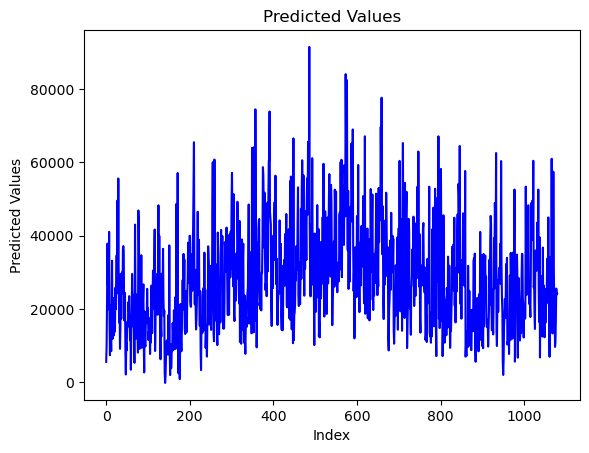

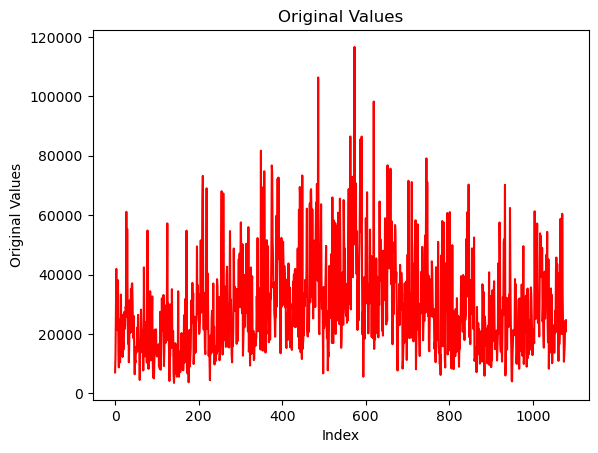

In [15]:
import matplotlib.pyplot as plt

def plot_array(array,label,color):
    plt.plot(array, color)
    plt.xlabel('Index')
    plt.ylabel(label)
    plt.title(label)
    plt.show()


plot_array(predictionArray[:], 'Predicted Values','blue')
plot_array(y_test.to_numpy()[:], 'Original Values','red')

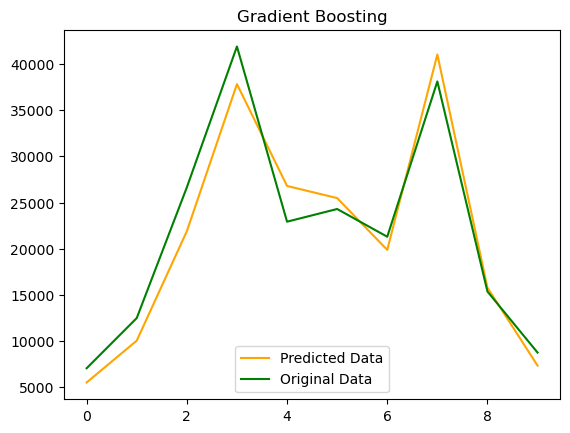

In [16]:
def plot_array(title,array1,label1,color1,array2,label2,color2):
    plt.plot(array1, color1, label=label1 )
    plt.plot(array2,color2,label=label2 )
    plt.title(title)
    plt.legend()
    plt.show()


plot_array('Gradient Boosting',predictionArray[0:10],'Predicted Data', 'orange',y_test.to_numpy()[0:10],"Original Data",'green')